In [65]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
from analysis.lib.purification import purify_pq as ppq; reload(ppq)
%matplotlib inline
# folder=tb.latest_data('lt3_SPCORR')
folder=tb.latest_data('SPCorrs')
#folder = r'D:\measuring\data\20151127\110547_Bell_lt3_SPCORR_ZPL_SPCORR_lt3'
print 'folder :', folder 
name = 'ssro'
a = ppq.purify_pq(folder, hdf5_mode='r')#, pq_folder='bs_remote')

d:\measuring\data
folder : d:\measuring\data\20160606\152547_Purification_Pippin_SIL2_SPCorrs_ZPL_BK


(<matplotlib.figure.Figure at 0x159faa90>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x159facd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x158e8cd0>))

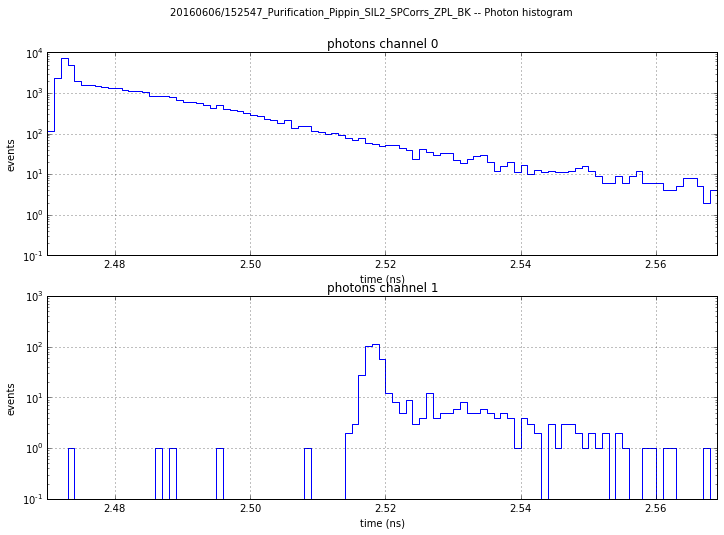

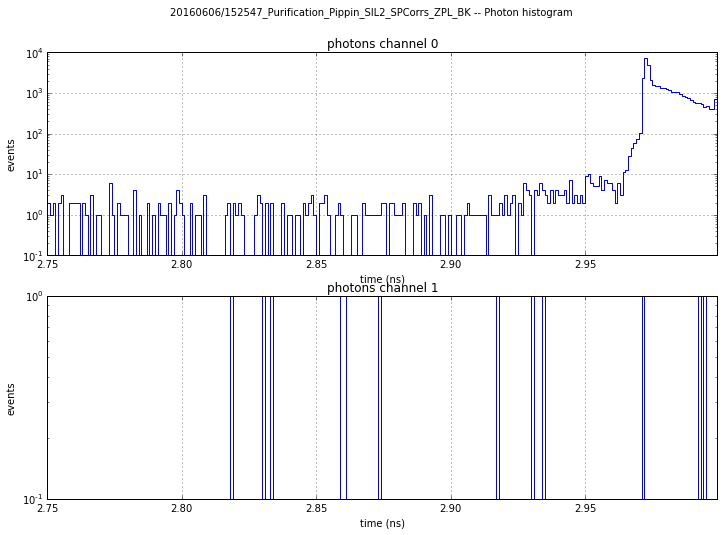

In [77]:
pq_plots.plot_photon_hist(a.pqf,start = 2470,  length = 100, hist_binsize = 1., save = False, log=True) #start =7480
pq_plots.plot_photon_hist(a.pqf,start = 2750,  length = 250, hist_binsize = 1., save = False, log=True) #start =7480

In [54]:
ro_channel    = 0
photon_channel = 0
ro_start      = 10730 
ro_length     = 3700

st_start = 2750 if photon_channel==0 else 2805
st_len       = 50 #50 ns
st_len_w2    = 50
p_sep        = 2730 #600 ns

In [55]:
# In the data structure, photon detector clicks are saved with a some associated parameters (channel, time, trial...)
sp_lt = a.pqf['/PQ_special-1'].value # Special: marker channel
ch_lt = a.pqf['/PQ_channel-1'].value # Channel: photon channel
sn_lt = a.pqf['/PQ_sync_number-1'].value # Sync number: the number of the last sync signal
st_lt = a.pqf['/PQ_sync_time-1'].value # Sync time: time that has passed since the last sync signal
#tt_lt = a.pqf['/PQ_time-1'].value 

In [56]:
### filter the PQ data
st_fltr_w1 = (sp_lt == 0) & (ch_lt == photon_channel)  & (st_lt > st_start)  & (st_lt < (st_start  + st_len))
st_fltr_w2 = (sp_lt == 0) & (ch_lt == photon_channel)  & (st_lt > st_start + p_sep)  & (st_lt < (st_start + p_sep + st_len_w2))
#fltr_ro    = (sp_lt == 0) & (ch_lt == ro_channel)  & (st_lt > ro_start)  & (st_lt < (ro_start  + ro_length))   


In [57]:
### filter the adwin RO data according to the now filtered pq data
adwin_filter_w1 = a.filter_adwin_data_from_pq_syncs(st_fltr_w1)
adwin_filter_w2 = a.filter_adwin_data_from_pq_syncs(st_fltr_w2)

In [58]:
#JB
# The sync number identifies detector clicks that were measured in the same trial
# Create a filter that selects all detector clicks from the PSB channel when the laser was on
fltr_PBS_laserOn = (sp_lt == 0) & (ch_lt == 0) & (st_lt > 7573) & (st_lt < 7660)
# Create a filter that selects all detector clicks from the ZPL channel when the laser was off
fltr_ZPL_laserOff = (sp_lt == 0) & (ch_lt == 1) & (st_lt > 7603) & (st_lt < 7630)
# Retreive sync number for detector clicks that pass filter 1
sn_PBS_laserOn = sn_lt[fltr_PBS_laserOn]
# Retreive sync number for detector clicks that pass filter 2
sn_ZPL_laserOff =sn_lt[fltr_ZPL_laserOff]
# Find sync numbers that occur in both groups
sn_filtered = sn_PBS_laserOn[np.in1d(sn_PBS_laserOn, sn_ZPL_laserOff)]
print 'Total number of detector clicks:', len(fltr_PBS_laserOn)
print 'Total number of trials:', len(np.unique(sn_lt))
print 'Trials with a click on PBS channel while laser is on:', len(np.unique(sn_PBS_laserOn)), '(', (1.0 * len(np.unique(sn_PBS_laserOn))) / len(np.unique(sn_lt)) * 100, '%)'
print 'Trials with a click on ZPL channel while laser is off:', len(np.unique(sn_ZPL_laserOff)), '(', (1.0 * len(np.unique(sn_ZPL_laserOff))) / len(np.unique(sn_lt)) * 100, '%)'
print 'Trials with both a PBS photon with laser on and a ZPL photon with laser off:', len(sn_filtered) 

Total number of detector clicks: 4744
Total number of trials: 4360
Trials with a click on PBS channel while laser is on: 4 ( 0.0917431192661 %)
Trials with a click on ZPL channel while laser is off: 0 ( 0.0 %)
Trials with both a PBS photon with laser on and a ZPL photon with laser off: 0


In [59]:
noof_reps = len(np.unique(sn_lt))
noof_reps2= a.agrp['completed_reps'].value*a.g['joint_params'].attrs['LDE_attempts']

w1_sn = sn_lt[st_fltr_w1]
w2_sn = sn_lt[st_fltr_w2]
noof_w1_ro0 = np.sum(a.agrp['ssro_results'].value[adwin_filter_w1])
noof_w2_ro0 = np.sum(a.agrp['ssro_results'].value[adwin_filter_w2])
noof_w1 = np.sum(st_fltr_w1)
noof_w2 = np.sum(st_fltr_w2)
print noof_w1,noof_w2

IndexError: too many indices for array

In [60]:
print noof_reps,noof_reps2, noof_w1_ro0, noof_w2_ro0, noof_w1, noof_w2
print 'missed syncs', float(noof_reps)/noof_reps2
print 'tail_cts', float(noof_w1+noof_w2)/noof_reps2*1e4
print "RO's", noof_w1_ro0,noof_w2_ro0

4360 20966 168 821 334 1569
missed syncs 0.207955737861
tail_cts 907.660020986
RO's 168 821


In [61]:
reload(ppq)
ssro_calib_folder  = tb.latest_data('SSROCalib')
ro_time = a.agrp.attrs['E_RO_durations'][0]
#sweep_index , what does it do??
ssro_fids = ppq.get_analysed_fast_ssro_calibration(ssro_calib_folder,readout_time = ro_time)


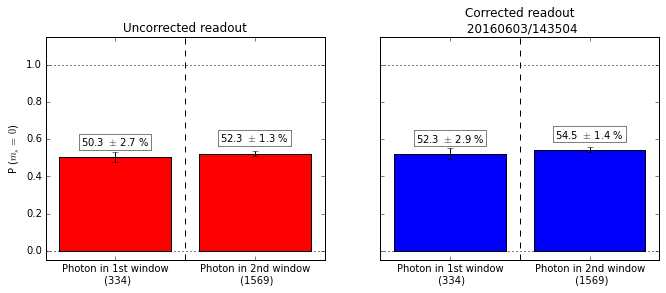

In [62]:
# P_ms1 generally stands for the probability to measure ms=1
# P_photon is the probability for getting a photon
win1_P_photon = float(noof_w1_ro0)/noof_w1
u_win1_P_photon = np.sqrt(win1_P_photon * (1.-win1_P_photon)/noof_w1)

win2_P_photon = float(noof_w2_ro0)/noof_w2
u_win2_P_photon = np.sqrt(win2_P_photon * (1.-win2_P_photon)/noof_w2)

fig, (ax, ax_corr) = plt.subplots(1,2, figsize=(11,4),
                              sharex=True, sharey=True)

### uncorrected for e-SSRO
ax.bar(range(2), [win1_P_photon, win2_P_photon], color=['r', 'r'],
       align='center', yerr=[u_win1_P_photon, u_win2_P_photon], ecolor='k',
       width=0.8)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.05, 1.15)

ax.set_ylabel('P ($m_s =\, 0$)')

ax.set_xticks([0,1])
ax.set_xticklabels(['Photon in 1st window \n ({})'.format(noof_w1),
                    'Photon in 2nd window \n ({})'.format(noof_w2)])
ax.axvline(0.5, c='k', ls='--')
ax.axhline(0, c='k', ls=':')
ax.axhline(1, c='k', ls=':')

ax.text(0, win1_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P_photon*100, u_win1_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.text(1, win2_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P_photon*100, u_win2_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.set_title('Uncorrected readout')

### corrected for e-SSRO
win1_P0, u_win1_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win1_P_photon, u_win1_P_photon, 
                                                                     *ssro_fids)
win2_P0, u_win2_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win2_P_photon, u_win2_P_photon,
                                                                     *ssro_fids)

ax_corr.bar(range(2), [win1_P0, win2_P0], color=['b','b'],
       align='center', yerr=[u_win1_P0, u_win2_P0], ecolor='k',
       width=0.8)
ax_corr.axvline(0.5, c='k', ls='--')
ax_corr.axhline(0, c='k', ls=':')
ax_corr.axhline(1, c='k', ls=':')

ax_corr.text(0, win1_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P0*100, u_win1_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.text(1, win2_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P0*100, u_win2_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.set_title('Corrected readout \n '+a.timestamp)
#fig.savefig(os.path.join(folder, 'Spin-photon_correlations.png'))

In [63]:
hist(st_lt[fltr_ro][np.in1d(ro0_sn,w2_sn)])

In [64]:
print 'PSB SP corr from date : {}'.format(tb.get_plot_title_from_folder(folder)[:15])
print '\tTail counts : {:.1f} '. format(float(noof_w1+noof_w2)/noof_reps*1e4)
print '\tRatio of photons detected in w1/w2 : {:.1f} %'.format(np.float(noof_w1)/noof_w2*100)
print '\tUncorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P_photon*100, u_win1_P_photon*100,win2_P_photon*100, u_win2_P_photon*100)
print '\tCorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P0*100, u_win2_P0*100,win2_P0*100, u_win2_P0*100)
if win1_P_photon*100 <2.5 and win2_P_photon*100>93.5 and np.float(noof_w1)/noof_w2*100 > 94 and np.float(noof_w1)/noof_w2*100<106:
    print 'all thresholds (93.5 and 2.5 and 94:106) are met.'
else:
    print 'threasholds are NOT met. Compare to threashold: 93.5 and 2.5 and 94:106'

PSB SP corr from date : 20160603/143504
	Tail counts : 4364.7 
	Ratio of photons detected in w1/w2 : 21.3 %
	Uncorrected readout : W1 : 50.3 +/- 2.7 % & W2 : 52.3 +/- 1.3 %
	Corrected readout : W1 : 52.3 +/- 1.4 % & W2 : 54.5 +/- 1.4 %
threasholds are NOT met. Compare to threashold: 93.5 and 2.5 and 94:106
